In [5]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Задаем нелинейную модель

In [6]:
# model to be studied
def model(u):
    return np.array([u**2+1, 2*max(u, 0)])

In [7]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

### Вычислим константы
Используем четырехточечный шаблон - якобиан трехдиагональная матрица. Следовательно все линейно
$$
t_{res} = C_f \cdot N \\
t_{jac} = C_j \cdot N \\
t_{lin} = C_l \cdot N
$$
Примечание: вообще говоря это не константы и от задачи к задаче они будут меняться, но нам просто нужно получть представление о соотношениии порядков

In [8]:
Nt = 10

# obtain random coeficents
coefs = np.random.rand(7)

t_res = np.zeros((10, 4))
t_jac = np.zeros((10, 4))
t_lin = np.zeros((10, 4))

for i in range(0, 10):
    Nx = 2000 +i*200
    param ={'Nx': Nx, 'Nt' : Nt}
    # set initial condition
    x0 = np.ones(Nx)
    x = np.linspace(0, 1, Nx)
    for k in range(len(coefs)):
        x0 += (1-coefs[k])*np.sin(np.pi*k*x)
    x0 = x0.reshape(-1, 1)
    D = Diffusion(Nx, 0.9, 1, 2e-2, model=model)
    bd1 = x0[0]
    bd2 = x0[-1]
    
    prob = one_phase(D, param)
    solver_n = fxbd_1D(param, prob)
    solver_n.setBoundary(bd1, bd2)
    nl_solver = newton(crit_abs=1e-6)
    solver_n.setSolver(nl_solver)
    solver_n.setInitial(x0)
    
    for j in range(4):
        solver_n.init_log()
        _, mes = solver_n.solve(tmax=0.1)
        sum_k = np.sum(solver_n.timelog.kn)
        t_res[i, j] = solver_n.timelog.res/((sum_k+1)*10)
        t_jac[i, j] = solver_n.timelog.jac/((sum_k)*10)
        t_lin[i, j] = solver_n.timelog.lin/((sum_k)*10)
        
    print(Nx, np.mean(t_res[i, :]), np.mean(t_jac[i, :]), np.mean(t_lin[i, :]), mes)

2000 0.008356591507240578 0.006306375448520366 0.0034351850931461044 OK
2200 0.00906367301940918 0.007273235000096835 0.004130434302183298 OK
2400 0.009647488814813119 0.007968275363628683 0.004865171588384188 OK
2600 0.010569400036776507 0.00893890720147353 0.005768793133588938 OK
2800 0.012720435857772827 0.010721256411992586 0.0069590362218710095 OK
3000 0.012344379336745651 0.010890016188988319 0.007769438853630652 OK
3200 0.012936514174496686 0.011544179228635935 0.008478684838001545 OK
3400 0.013636244888658876 0.012396311989197363 0.009520276693197396 OK
3600 0.014698708498919452 0.013714492321014404 0.01061986547250014 OK
3800 0.015162402832949604 0.014331692457199096 0.011618583935957688 OK


[3.92540291e-06] [[1.30236516e-07]]
[4.53184471e-06] [[8.86812868e-08]]
[4.39135775e-06] [[6.18319072e-08]]


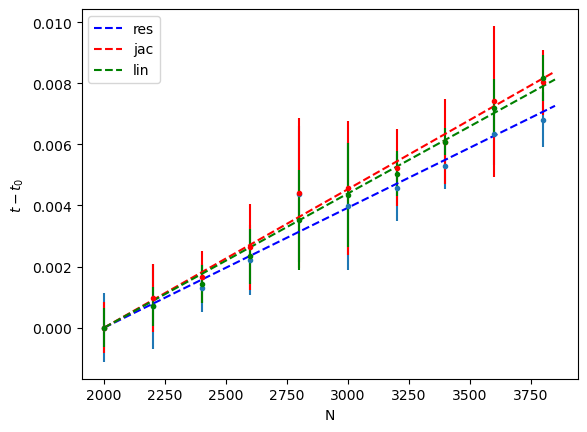

In [9]:
Nx = np.arange(2000, 2000+9*200+1, 200)

from scipy.optimize import curve_fit
def func(x, a):
    return x*a

plt.ylabel('$t-t_0$')
plt.xlabel('N')
plt.errorbar(Nx, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0],yerr= np.sqrt(np.std(t_res, axis=1))/10, marker='.', linestyle='')
plt.errorbar(Nx, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0],yerr= np.sqrt(np.std(t_jac, axis=1))/10,marker='.', linestyle='', color='r')
plt.errorbar(Nx, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0],yerr= np.sqrt(np.std(t_lin, axis=1))/10,marker='.',linestyle='', color='g')

popt, pcov = curve_fit(func, Nx-2000, np.mean(t_res, axis=1)-np.mean(t_res, axis=1)[0])
print(popt, np.sqrt(pcov))
c_r = popt[0]
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='b', label='res', linestyle='--')
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_jac, axis=1)-np.mean(t_jac, axis=1)[0])
print(popt, np.sqrt(pcov))
c_j = popt[0]
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='r', label='jac', linestyle='--')
popt, pcov = curve_fit(func, Nx-2000, np.mean(t_lin, axis=1)-np.mean(t_lin, axis=1)[0])
print(popt, np.sqrt(pcov))
plt.plot([2000, 3850], [0, popt[0]*(2850-1000)], color='g', label='lin', linestyle='--')
c_l = popt[0]

plt.legend()
plt.savefig('./data/constants.png', dpi=300)
plt.show()

### Зададим начальное условие, с которым будем работать
Пока возьмем какое-то одно и накинем сверху еще источник для усложнения

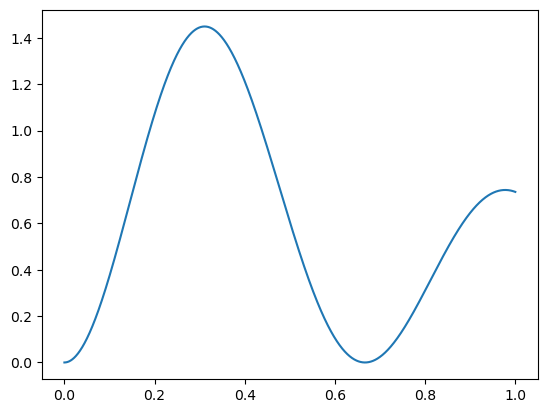

In [31]:
Nx = 2000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)
x0 = 2*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

plt.plot(x, x0)
plt.show()

### Решим задачу использую солвер с методом Ньютона

In [43]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.625], [-0.6])

In [44]:
nl_solver = newton(crit_abs=1e-10)
solver_n.setSolver(nl_solver)

In [45]:
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 8.321 +- 0.5071
mean newton iterations:  4.4


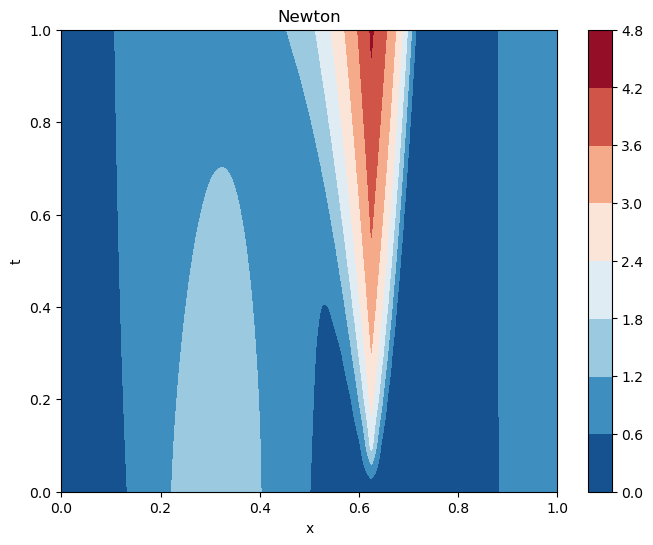

In [46]:
wp.show_res(solver_n)
plt.show()

In [47]:
cost_new = solver_n.timelog.kn*Nx*(c_r+c_j+c_l)+c_r*Nx

### Теперь используем стандартный ASPEN

In [101]:
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [102]:
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-10)
solver.setSolver(nl_solver)

In [103]:
X, mes, t, delta = test(solver, sample_size=4)

test started
verdict : OK
time : 14.93 +- 0.7742
mean aspen iterations:  3.5


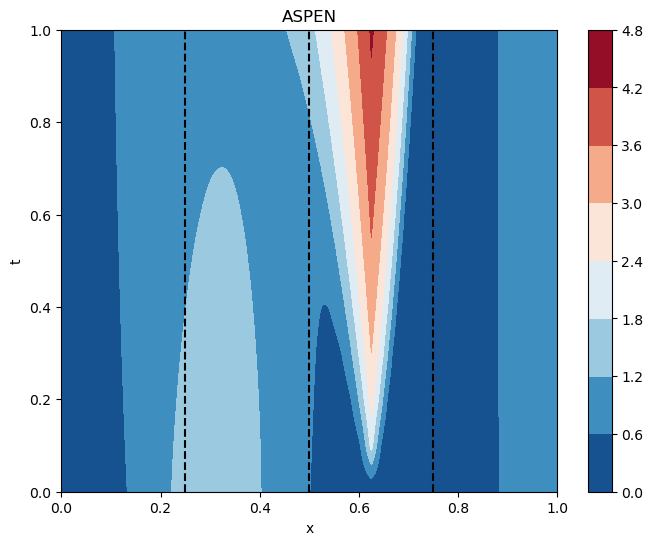

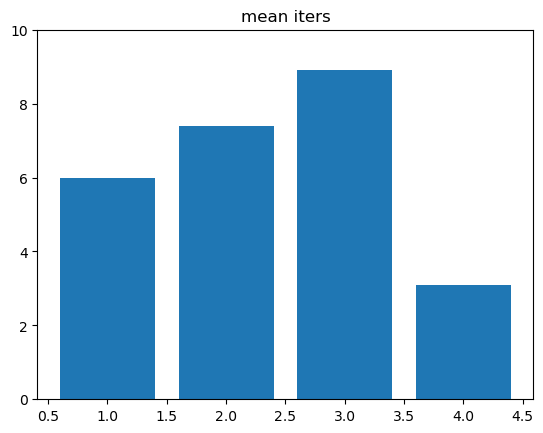

In [104]:
wp.show_res(solver, save='Diff0_ASPEN')
wp.bar_loc(solver, Nd, save='Diff0_mean_loc')

In [105]:
cost_eq = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))

--time comparision--
newton : 8.083603382110596
aspen : 14.318357706069946


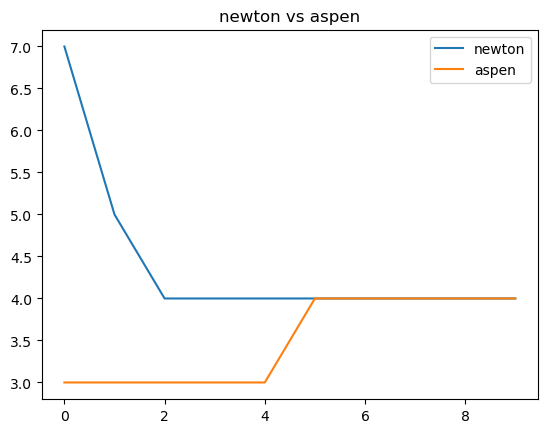

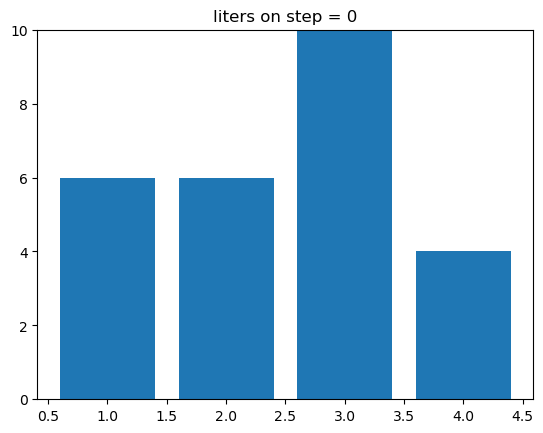

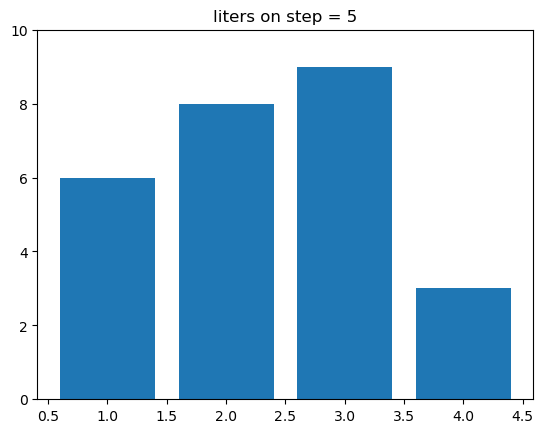

In [106]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp')
wp.bar_loc_step(solver, Nd, 0)#, save='step=0')
wp.bar_loc_step(solver, Nd, 5)#, save='step=5')

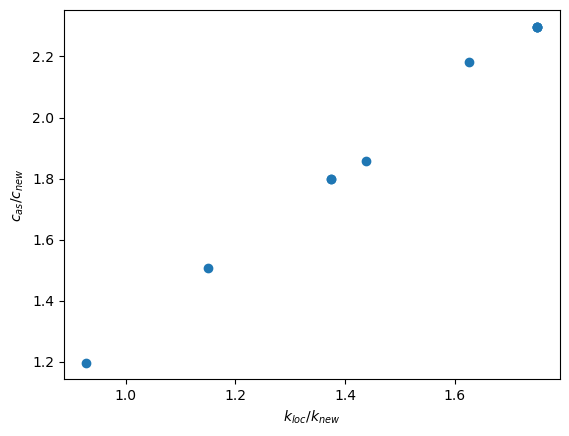

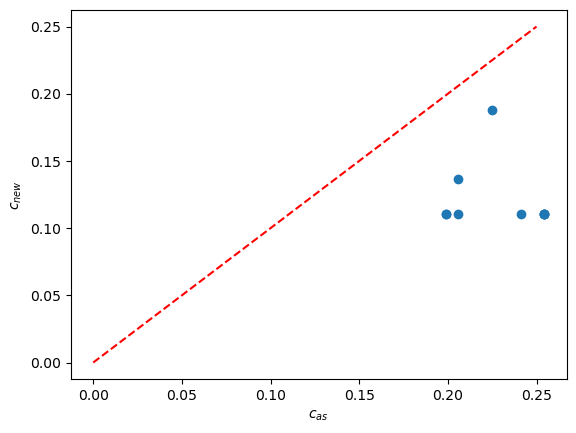

In [107]:
plt.scatter((np.mean(solver.timelog.domain_iters, axis = 0) ) \
            /solver_n.timelog.kn , cost_eq/cost_new)
plt.xlabel('$k_{loc}/k_{new}$')
plt.ylabel('$c_{as}/c_{new}$')
plt.savefig('./data/const_over_time_eq', dpi = 300)
plt.show()

#x = (solver_n.timelog.kn-solver.timelog.aspen_iters)/solver_n.timelog.kn
plt.scatter(cost_eq, cost_new)
plt.plot([0, 0.25], [0, 0.25], linestyle='--', color='r')
#plt.scatter(x, (cost_new-cost_eq)/cost_new)
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
plt.savefig('./data/const_over_k_eq', dpi = 300)
plt.show()

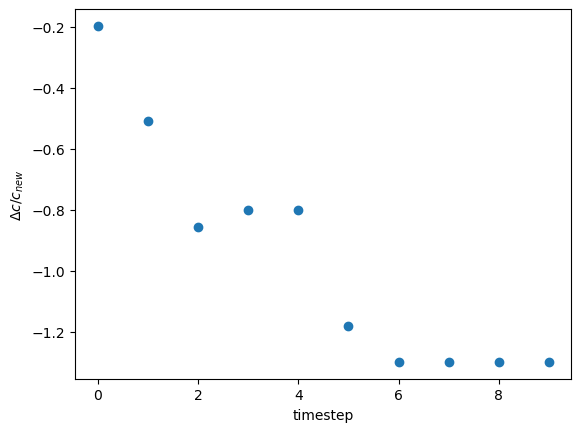

In [110]:
plt.scatter(np.arange(Nt), (cost_new-cost_eq)/cost_new)
plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_otime_eq', dpi = 300)
plt.show()

### Иследуем зависимость скорости от погрешности локальной стадии
Тут идея такая: раз у нас получилось много иттераций в локальной стадии, то попробуем задать для неё более мягкий критерий. Нет необходимости считать локлаьные домены слишком точно - все равно на глобальной стадии возникнет поправка

In [123]:
Nd = 4
Nx = 2000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

In [124]:
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs = 1e-10)
solver.setSolver(nl_solver)

In [125]:
time = np.zeros(10)
delta = np.zeros(10)
gb_iters = np.zeros((10, Nt))
lc_iters = np.zeros((10, Nd, Nt))
Cost_softloc = np.zeros((10, Nt))

i = 0
for loc in np.logspace(-10, -5, 10):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-8, crit_loc = loc)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 14.91 +- 0.6111
mean aspen iterations:  3.4
test started
verdict : OK
time : 14.24 +- 0.3379
mean aspen iterations:  3.4
test started
verdict : OK
time : 14.12 +- 0.509
mean aspen iterations:  3.4
test started
verdict : OK
time : 13.86 +- 0.317
mean aspen iterations:  3.4
test started
verdict : OK
time : 13.73 +- 0.3856
mean aspen iterations:  3.4
test started
verdict : OK
time : 13.59 +- 0.2677
mean aspen iterations:  3.4
test started
verdict : OK
time : 13.32 +- 0.3725
mean aspen iterations:  3.4
test started
verdict : OK
time : 12.89 +- 0.2354
mean aspen iterations:  3.4
test started
verdict : Not converged
time : 7.142 +- 0.3553
mean aspen iterations:  1.8
8 Not converged
test started
verdict : Not converged
time : 0.0 +- 0.0
mean aspen iterations:  0.0
9 Not converged


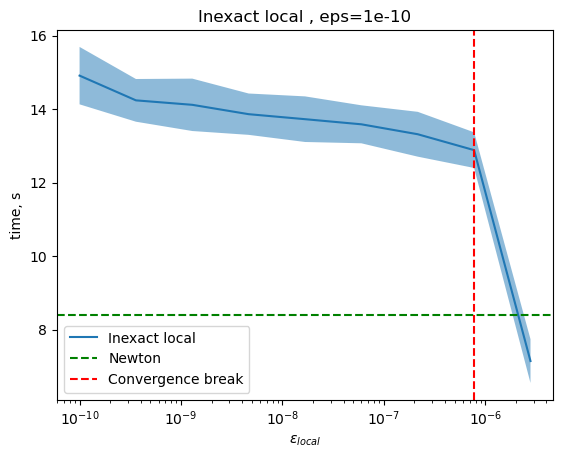

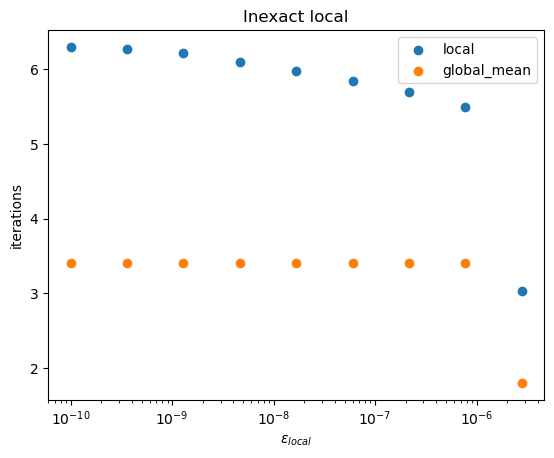

In [129]:
crit_rel = np.logspace(-10, -5, 10)

plt.title('Inexact local , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.plot(crit_rel[:-1], time[:-1], label='Inexact local')
plt.fill_between(crit_rel[:-1], time[:-1]+np.sqrt(delta[:-1]),
                time[:-1]-np.sqrt(delta[:-1]), alpha=0.5)
plt.axhline(8.4, color='g', linestyle='--', label='Newton')
plt.axvline(np.logspace(-10, -5, 10)[7], color='r', linestyle='--', label='Convergence break')
plt.legend()
plt.savefig('./data/Diff0_I_time', dpi=400)
plt.show()

plt.title('Inexact local')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.scatter(crit_rel[:-1], np.mean(np.mean(lc_iters, axis = 2), axis = 1)[:-1], label='local')
plt.scatter(crit_rel[:-1], np.mean(gb_iters, axis = 1)[:-1], label='global_mean')
plt.legend()
plt.savefig('./data/Diff0_I_lc_iters', dpi=400)
plt.show()

In [116]:
print(gb_iters, lc_iters, Cost_softloc)

[[3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [[[ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
  [ 6.  6.  6.  6.  6.  7.  9.  9.  9.  9.]
  [10.  8.  8.  7.  7.  8. 10. 10. 10. 10.]
  [ 4.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
  [ 6.  6.  6.  6.  6.  7.  9.  9.  9.  9.]
  [10.  8.  7.  7.  7.  8. 10. 10. 10. 10.]
  [ 4.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  6.  6.  6.  6.  6.  6.  6.  6.  6.]
  [ 6.  6.  6.  6.  6.  7.  9.  9.  9.  9.]
  [10.  8.  7.  7.  7.  7. 10. 10. 10. 10.]
  [ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]]

 [[ 6.  6.  6.  6.  6.  6.  6.  6.  5.  5.]
  [ 6.  6.  6.  6.  6.  6.  8.  9.  9.  9.]
  [10.  8.  7.  7.  7.  7.  9. 10. 10. 10.]
  [

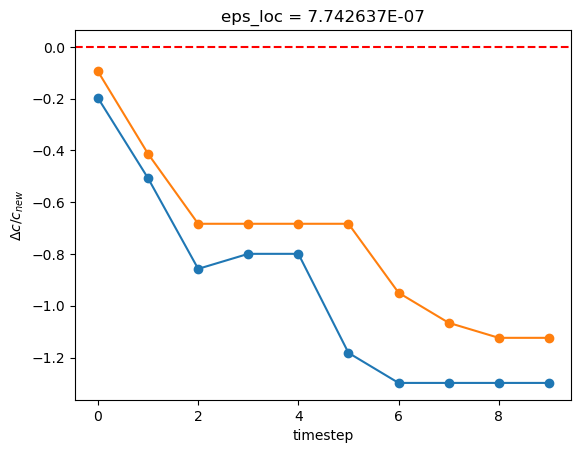

In [119]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[7, :])/cost_new, marker='o')
plt.title('eps_loc = {:4E}'.format(np.logspace(-10, -5, 10)[7]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.savefig('./data/const_comp_over_time_eq', dpi = 300)
plt.show()

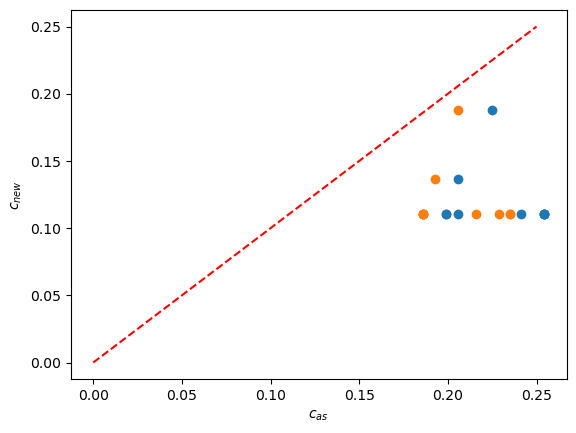

In [118]:
#x = (solver_n.timelog.kn-solver.timelog.aspen_iters)/solver_n.timelog.kn
plt.scatter(cost_eq, cost_new)
plt.scatter(Cost_softloc[7, :], cost_new)
plt.plot([0, 0.25], [0, 0.25], linestyle='--', color='r')
plt.xlabel('$c_{as}$')
plt.ylabel('$c_{new}$')
#plt.savefig('./data/const_over_k_eq', dpi = 300)
plt.show()

### Введем относительную погрешность
Изначально, в ASPEN задается абсолютный критерий, но введем наряду с ним в локальной стадии относительную погршеность.

In [132]:
Nd = 4
Nx = 2000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
param ={'Nx': Nx, 'Nt' : Nt}
D = Diffusion(Nx, 0.9, 1, 0.2e-2, model=model)

prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.625], [-0.6])
solver.setInitial(x0)

partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs = 1e-10)
solver.setSolver(nl_solver)

In [133]:
time = np.zeros(20)
delta = np.zeros(20)
gb_iters = np.zeros((20, Nt))
lc_iters = np.zeros((20, Nd, Nt))
Cost_softloc = np.zeros((20, Nt))

i = 0
for crit_rel in np.logspace(-10, -1, 20):
    nl_solver = aspen(Nd, partion, crit_abs = 1e-10, crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    Cost_softloc[i, :] = Nx*( (c_r+c_l)*solver.timelog.aspen_iters+c_r
    + np.mean(solver.timelog.domain_iters, axis = 0)*(c_r+c_l+c_j))
    i += 1

test started
verdict : OK
time : 13.9 +- 0.9103
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.43 +- 0.2231
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.31 +- 0.2104
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.29 +- 0.2948
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.31 +- 0.1774
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.17 +- 0.158
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.06 +- 0.2184
mean aspen iterations:  3.5
test started
verdict : OK
time : 12.82 +- 0.2305
mean aspen iterations:  3.5
test started
verdict : OK
time : 12.82 +- 0.5073
mean aspen iterations:  3.5
test started
verdict : OK
time : 13.21 +- 0.5711
mean aspen iterations:  3.5
test started
verdict : OK
time : 12.83 +- 0.5609
mean aspen iterations:  3.5
test started
verdict : OK
time : 12.36 +- 0.2428
mean aspen iterations:  3.5
test started
verdict : OK
time : 11.96 +- 0.2924
mean aspen iterations:  3.5
t

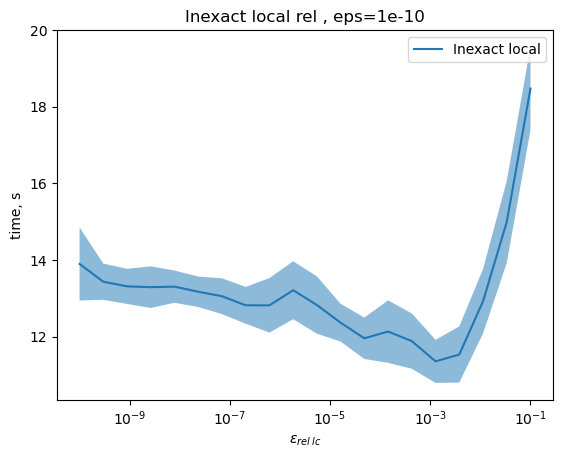

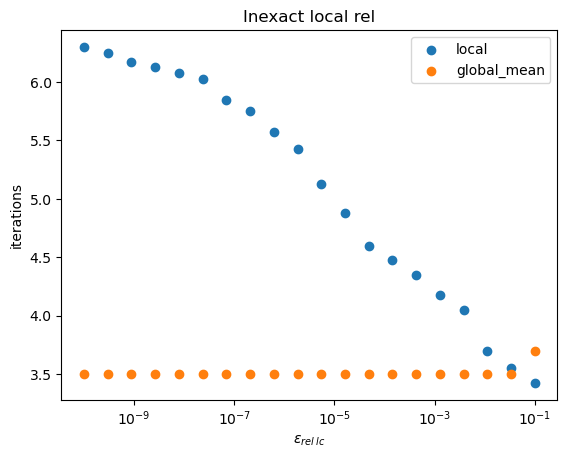

In [138]:
crit_rel = np.logspace(-10, -1, 20)

plt.title('Inexact local rel , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{rel \; lc}$')
plt.xscale('log')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/rel0_Diff0_I_time', dpi=400)
plt.legend()
plt.show()

plt.title('Inexact local rel')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{rel \; lc}$')
plt.xscale('log')
plt.scatter(crit_rel, np.mean(np.mean(lc_iters, axis = 2), axis = 1), label='local')
plt.scatter(crit_rel, np.mean(gb_iters, axis = 1), label='global_mean')
plt.legend()
plt.savefig('./data/rel0_Diff0_I_lc_iters', dpi=400)
plt.show()

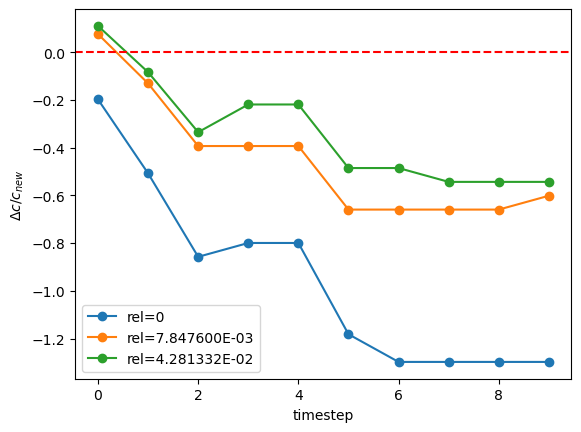

In [139]:
plt.plot(np.arange(Nt), (cost_new-cost_eq)/cost_new, marker='o', label='rel=0')
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[16, :])/cost_new, marker='o',
         label='rel={:4E}'.format(np.logspace(-8, -1, 20)[16]))
plt.plot(np.arange(Nt), (cost_new-Cost_softloc[18, :])/cost_new, marker='o',
         label='rel={:4E}'.format(np.logspace(-8, -1, 20)[18]))
plt.axhline(0, linestyle='--', color='r')

plt.xlabel('timestep')
plt.ylabel('$\Delta c/c_{new}$')
plt.legend()
plt.savefig('./data/rel_comp_over_time_eq', dpi = 300)
plt.show()

In [ ]:
print(gb_iters)